In [1]:
pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from fredapi import Fred
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


In [3]:
fred = Fred(api_key="27e6b12c3fe162251565c96757199257")

# 1. EDA

In [4]:
def get_data(feature, name, standardize=True):
  df = fred.get_series_all_releases(feature)
  df = df[df.value.notnull()]
  df = df[df["date"] >= datetime.datetime(1982, 1, 1)]
  df = df[df["date"] <= datetime.datetime(2023, 2, 2)]
  df = df.groupby('date', as_index=False).last()
  df = df.drop("realtime_start", axis=1)
  if standardize:
    df["value"] = (df["value"]-df["value"].mean())/df["value"].std() # Standardize
  df.columns = ["date", name]
  return df

In [5]:
GDP = get_data("gdp", "GDP") # quarterly GDP
P = get_data("POPTHM", "P") # Population
IR = get_data("REAINTRATREARAT10Y", "IR") # interest_rate
CPI = get_data("CPALTT01USM657N", "CPI")
W = get_data("LES1252881600Q", "W") # Wage
# PC = get_data("USASACRMISMEI", "PC") # Passenger Car Registrations for US
IP = get_data("INDPRO", "IP") # Industrial Production: Total Index
M2 = get_data("M2SL", "M2") # M2
# LT = get_data("IRLTLT01USM156N", "LT") # Long-Term Government Bond Yields: 10-year
# OP = get_data("MCOILBRENTEU", "OP") # Crude Oil Prices: Brent - Europe (Monthly)
OC = get_data("OECDCPALTT01GYM", "OC") # International: OECD CPI
R = get_data("RECPROUSM156N", "R", standardize=False) # Smoothed U.S. Recession Probabilities

In [6]:
R['R'] = pd.cut(x=R['R'], bins=[0, 15, 100], labels=[0, 1])

In [7]:
# R['recession'] = pd.cut(x=R['R'], bins=[0, 15, 100], labels=['No', 'Yes'])
# R = pd.concat([R.date, pd.get_dummies(R.recession, prefix='RecessionIndicator')], axis=1)
R

,date,R
0,1982-01-01,1
1,1982-02-01,0
2,1982-03-01,1
3,1982-04-01,1
4,1982-05-01,1
...,...,...
489,2022-10-01,0
490,2022-11-01,0
491,2022-12-01,0
492,2023-01-01,0


In [8]:
ym = get_data("LNS14000001", "ym", standardize=False) # Unemployment Rate - Men
yw = get_data("LNS14000002", "yw", standardize=False) # Unemployment Rate - Women
y = get_data("UNRATE", "y", standardize=False) # Unemployment Rate

In [9]:
y.y = np.log(y.y)

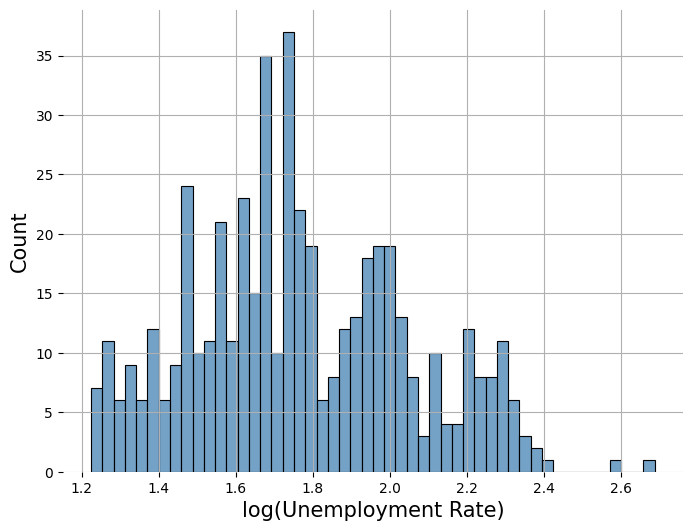

In [10]:
plt.figure(figsize=(8, 6))
sns.set_palette("hls")     
sns.histplot(y.y,color="steelblue",bins=50)
plt.xlabel('log(Unemployment Rate)',fontsize=15)
plt.ylabel('Count',fontsize=15)   
plt.grid(linestyle='-')   
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)
plt.show()


In [11]:
data = y
for df in [ym, yw, GDP, P, IR, CPI, W, IP, M2, R, OC]:
  data = pd.merge(data, df, on="date", how="left")
data.fillna(method='ffill', inplace=True)

In [12]:
data

,date,y,ym,yw,GDP,P,IR,CPI,W,IP,M2,R,OC
0,1982-01-01,2.151762,8.7,8.5,-1.417519,-1.684400,2.757811,0.250303,-1.255432,-1.890368,-1.078808,1,2.211851
1,1982-02-01,2.186051,8.8,8.9,-1.417519,-1.679572,2.775386,0.247235,-1.255432,-1.835001,-1.078014,0,2.090539
2,1982-03-01,2.197225,9.1,8.9,-1.417519,-1.674468,2.493576,-1.033366,-1.255432,-1.853629,-1.075691,1,1.954983
3,1982-04-01,2.230014,9.4,9.3,-1.408111,-1.669271,2.642773,0.564927,-1.134471,-1.878736,-1.072321,1,1.958326
4,1982-05-01,2.240710,9.4,9.3,-1.408111,-1.663921,2.595611,2.151429,-1.134471,-1.897008,-1.070094,1,2.044587
...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,2022-10-01,1.308333,3.7,3.7,2.312355,1.479864,-0.353955,0.511656,1.829083,1.144605,2.728474,0,2.142015
490,2022-11-01,1.280934,3.7,3.6,2.312355,1.484353,-0.282719,-1.019149,1.829083,1.125738,2.721812,0,2.005882
491,2022-12-01,1.252763,3.4,3.6,2.312355,1.488443,-0.472097,-1.641579,1.829083,1.037057,2.714221,0,1.697061
492,2023-01-01,1.223775,3.6,3.3,2.365842,1.491917,-0.361556,1.701751,1.829083,1.089828,2.686007,0,1.618182


<ipython-input-13-d7d388341b3d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.loc[:,~data.columns.isin(['R'])].corr())


<Axes: >

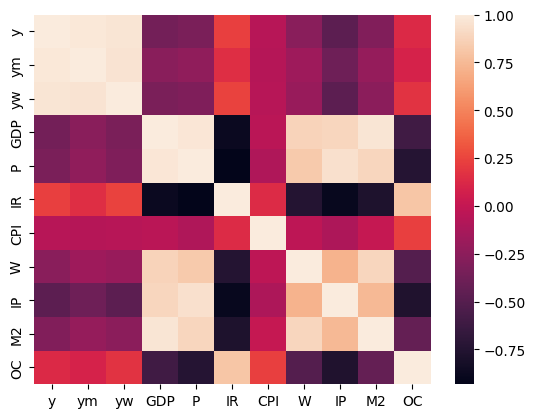

In [13]:
sns.heatmap(data.loc[:,~data.columns.isin(['R'])].corr())

<Axes: >

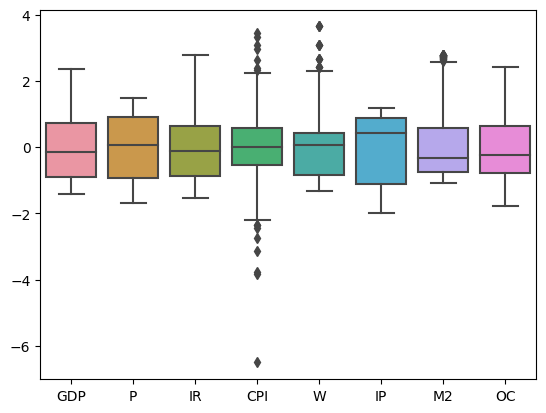

In [14]:
sns.boxplot(data.loc[:, ~data.columns.isin(['R','y','ym','yw'])])


In [15]:
data = sm.add_constant(data)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data.loc[:,~data.columns.isin(['date', 'y', 'ym', "yw"])], data.y, test_size = 0.2)

# 2. Linear Regression

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [18]:
model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test) 
model.summary()
results = pd.DataFrame()
results = results.append({'r2': r2_score(y_test, y_pred), 
                'mse': mean_squared_error(y_test,y_pred), 
                'mae': mean_absolute_error(y_test,y_pred),
                'model': 'Linear Regression',}, ignore_index = True)


<ipython-input-18-c236cd3dab1b>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'r2': r2_score(y_test, y_pred),


In [19]:
results

,r2,mse,mae,model
0,0.592129,0.033146,0.158218,Linear Regression


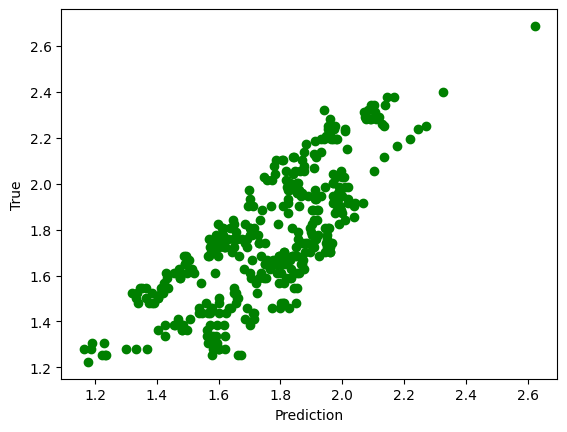

In [20]:
plt.scatter(model.predict(x_train), y_train, color="g")
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

## PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
fit = pca.fit(x_train)
pd.DataFrame(fit.components_,columns=x_train.columns)

,const,GDP,P,IR,CPI,W,IP,M2,R,OC
0,0.0,-0.401465,-0.412281,0.385997,0.029465,-0.360858,-0.389732,-0.373719,0.009804,0.311636
1,0.0,-0.103202,-0.001549,-0.075253,-0.900161,-0.154946,0.049784,-0.206884,0.013612,-0.322369
2,-0.0,0.187398,-0.014971,0.201922,-0.431255,0.345967,-0.218680,0.411805,0.006039,0.633065
3,-0.0,-0.242221,-0.215563,-0.009092,0.042061,0.718795,-0.452811,-0.068372,0.032489,-0.406910


In [22]:
x_pca = pca.fit_transform(x_train)
model = sm.OLS(y_train, x_pca).fit()
y_pred = model.predict(pca.transform(x_test)) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.5841
Date:                Mon, 08 May 2023   Prob (F-statistic):                       0.674
Time:                        21:01:33   Log-Likelihood:                         -788.72
No. Observations:                 395   AIC:                                      1585.
Df Residuals:                     391   BIC:                                      1601.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0395      0.037      1.065      0.288      -0.033       0.112
x2             0.0312      0.086      0.363      0.717      -0.138       0.200
x3            -0.0077      0.107     -0.072      0.943      -0.219       0.203
x4             0.2035      0.197      1.032      0.303      -0.184       0.591
==============================================================================
Omnibus:                       20.882   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.548
Skew:                           0.564   Prob(JB):                     1.27e-05
Kurtosis:                       2.688   Cond. No.                         5.32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
results = results.append({'r2': r2_score(y_test, y_pred), 
                'mse': mean_squared_error(y_test,y_pred), 
                'mae': mean_absolute_error(y_test,y_pred),
                'model': 'Linear Regression + PCA',}, ignore_index = True)


<ipython-input-23-23fbed14d7a8>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'r2': r2_score(y_test, y_pred),


PCA does not apply to small dataset, try Bootstrap instead.

## Bootstrap

In [24]:
from numpy.random import rand, randn, choice
from sklearn.utils import resample

In [25]:
stats = list()
models = list()
for i in range(1000):
    #prepare train & test sets
    sample_train_x, sample_train_y = resample(x_train.values, y_train.values, n_samples = 190) 
    sample_test_x, sample_test_y = resample(x_test.values, y_test.values, n_samples = 50) 
  
    #fit model
    # model = LinearRegression()
    # model.fit(sample_train_x, sample_train_y)
    # models.append(model)
    wi = np.linalg.lstsq(sample_train_x, sample_train_y, rcond=None)[0]
    models.append(wi)
    pred = sample_test_x @ wi
    score = r2_score(sample_test_y, pred)
    stats.append(score)

<Figure size 1000x500 with 0 Axes>

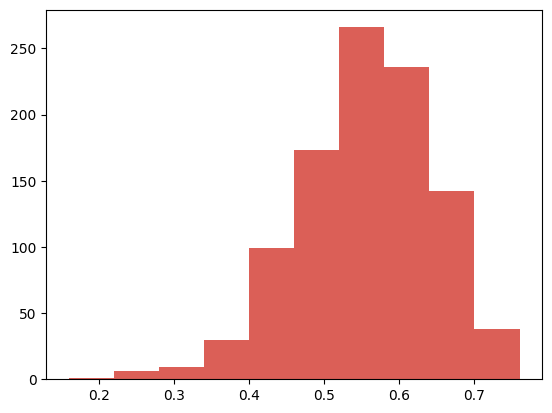

<Figure size 1000x500 with 0 Axes>

In [26]:
plt.hist(stats)
plt.figure(figsize = (10,5))

In [27]:
w = np.mean(models, axis=0)
y_pred = x_test @ w

In [28]:
r2_score(y_test, y_pred)

0.5929913600341801

In [29]:
results = results.append({'r2': r2_score(y_test, y_pred), 
                'mse': mean_squared_error(y_test,y_pred), 
                'mae': mean_absolute_error(y_test,y_pred),
                'model': 'Linear Regression + Bootstrap',}, ignore_index = True)


<ipython-input-29-bd1f92de631e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'r2': r2_score(y_test, y_pred),


Slightly better.

# 3. Support Vector Regression


In [30]:
from sklearn.svm import SVR


In [31]:
regressor = SVR(kernel='rbf')
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [32]:
results = results.append({'r2': r2_score(y_test, y_pred), 
                'mse': mean_squared_error(y_test,y_pred), 
                'mae': mean_absolute_error(y_test,y_pred),
                'model': 'SVR',}, ignore_index = True)


<ipython-input-32-243812c5f5a4>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'r2': r2_score(y_test, y_pred),


In [33]:
results.set_index('model')

,r2,mse,mae
model,,,
Linear Regression,0.592129,0.033146,0.158218
Linear Regression + PCA,-38.972117,3.248373,1.783946
Linear Regression + Bootstrap,0.592991,0.033076,0.158216
SVR,0.928553,0.005806,0.058959


SVM performs better than Linear Regression.

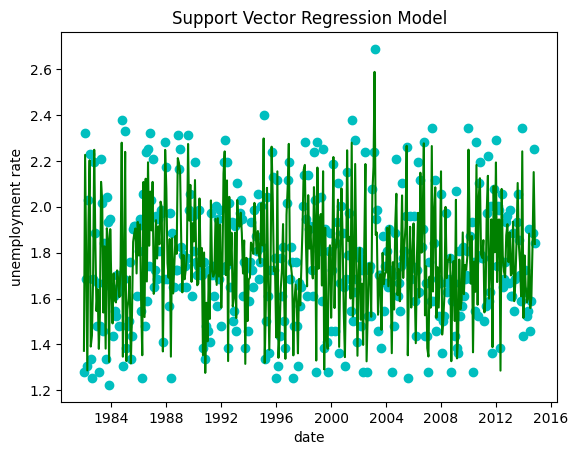

In [34]:
plt.scatter(data.iloc[:len(x_train),:]["date"], y_train, color="c")
plt.plot(data.iloc[:len(x_train),:]["date"], regressor.predict(x_train), color="g")
plt.title('Support Vector Regression Model')
plt.xlabel('date')
plt.ylabel('unemployment rate')
plt.show()

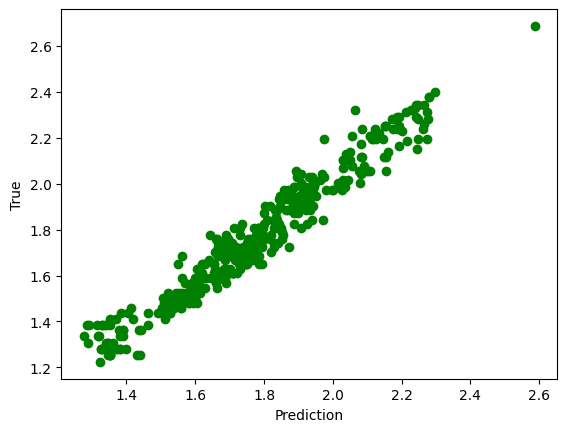

In [35]:
plt.scatter(regressor.predict(x_train), y_train, color="g")
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

# Gender Analysis

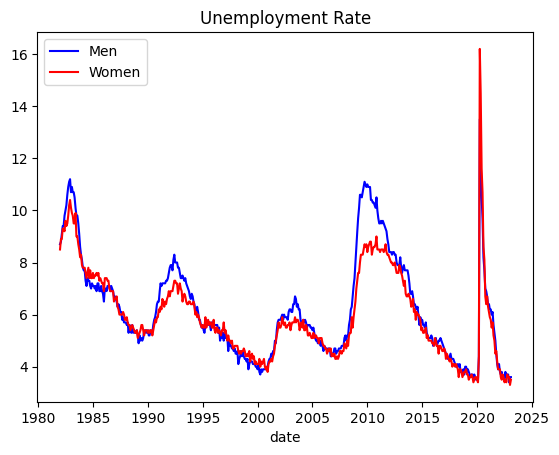

In [37]:
plt.plot(ym.date, ym.ym, color='b', label="Men")
plt.plot(yw.date, yw.yw, color='r', label="Women")
# plt.plot(y.date, y.y, color='c', label="Unemployment rate")
plt.title("Unemployment Rate")
plt.xlabel("date")
plt.legend()

In [38]:
ym['gender'] = 1 # Men
yw['gender'] = 0 # Women
yw.columns = ["date", "y", "gender"]
ym.columns = ["date", "y", "gender"]
ds = pd.concat([yw, ym], axis=0)

In [39]:
ds.y = np.log(ds.y)

In [40]:
for df in [GDP, P, IR, CPI, W, IP, M2, R, OC]:
  ds = pd.merge(ds, df, on="date", how="left")
ds.fillna(method='ffill', inplace=True)
ds.index = ds['date']
del ds['date']
ds.sort_index(inplace=True)

In [41]:
ds

,y,gender,GDP,P,IR,CPI,W,IP,M2,R,OC
date,,,,,,,,,,,
1982-01-01,2.140066,0,-1.417519,-1.684400,2.757811,0.250303,-1.255432,-1.890368,-1.078808,1,2.211851
1982-01-01,2.163323,1,-1.417519,-1.684400,2.757811,0.250303,-1.255432,-1.890368,-1.078808,1,2.211851
1982-02-01,2.186051,0,-1.417519,-1.679572,2.775386,0.247235,-1.255432,-1.835001,-1.078014,0,2.090539
1982-02-01,2.174752,1,-1.417519,-1.679572,2.775386,0.247235,-1.255432,-1.835001,-1.078014,0,2.090539
1982-03-01,2.186051,0,-1.417519,-1.674468,2.493576,-1.033366,-1.255432,-1.853629,-1.075691,1,1.954983
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,1.280934,0,2.312355,1.488443,-0.472097,-1.641579,1.829083,1.037057,2.714221,0,1.697061
2023-01-01,1.280934,1,2.365842,1.491917,-0.361556,1.701751,1.829083,1.089828,2.686007,0,1.618182
2023-01-01,1.193922,0,2.365842,1.491917,-0.361556,1.701751,1.829083,1.089828,2.686007,0,1.618182


In [42]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
sensitive_features = ds["gender"]

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    ds.loc[:,~ds.columns.isin(['y'])], ds.y, sensitive_features, test_size=0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

In [66]:
%pip install dalex
import dalex as dx 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1046022 sha256=e7d998566b53862bbce6079f1cd05affc86fae702419516912071153df0c5c46
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


In [50]:
# %pip install fairlearn
# from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.9 MB/s eta 0:00:00


In [129]:
regressor_l = LinearRegression()
regressor_l.fit(X_train, y_train)

forward_fs = sfs(estimator = regressor_l, k_features = 6, forward = True, verbose = 1, scoring = 'r2')
feature_names = ('Gender', 'GDP', 'P', 'IR', 'CPI', 'W', 'IP', 'M2', 'R', 'OC')
forward_fit = forward_fs.fit(X_train, y_train, custom_feature_names=feature_names)
print('R-Squared value:', forward_fit.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
Features: 6/6

R-Squared value: 0.5761071013209156


In [130]:
forward_fit.k_feature_names_

('GDP', 'P', 'IR', 'IP', 'R', 'OC')

In [68]:
# exp = dx.Explainer(regressor, X_test, y_test, verbose=False)

# protected = np.where(X_test.gender <= 0.5, 'men', "women")
# privileged = 'women'

# fobject = exp.model_fairness(protected, privileged)

# fobject.plot()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [135]:
regressor_sv = SVR()
regressor_sv.fit(X_train, y_train)

forward_fs = sfs(estimator = regressor_sv, k_features = 6, forward = True, verbose = 1, scoring = 'r2')
feature_names = ('Gender', 'GDP', 'P', 'IR', 'CPI', 'W', 'IP', 'M2', 'R', 'OC')
forward_fit = forward_fs.fit(X_train, y_train, custom_feature_names=feature_names)
print('R-Squared value:', forward_fit.k_score_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
Features: 1/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s finished
Features: 2/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s finished
Features: 3/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s finished
Features: 4/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished
Features: 5/6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
Features: 6/6

R-Squared value: 0.9416371535337698


In [137]:
forward_fit.k_feature_names_

('Gender', 'P', 'W', 'IP', 'M2', 'OC')

In [119]:
protected = np.where(X_test.gender >= 0.5, 'men', "women")
privileged = 'women'
# create Explainer objects 
exp_l  = dx.Explainer(regressor_l, X_test, y_test.values, verbose=False)
exp_sv  = dx.Explainer(regressor_sv, X_test.values, y_test.values, verbose=False)

# create fairness explanations
fobject_l = exp_l.model_fairness(protected, privileged)
fobject_sv = exp_sv.model_fairness(protected, privileged)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



In [127]:
fairness = fobject_sv.result

,independence,separation,sufficiency
subgroup,,,
men,1.010477,1.002643,1.000958


In [128]:
fobject_l

In [153]:
f1 = fobject_l.result
f1['model'] = 'LinearRegression'
f2 = fobject_sv.result
f2['model'] = 'SVR'
pd.concat([f1, f2])


,independence,separation,sufficiency,label,model
subgroup,,,,,
men,1.013982,1.005860,1.000061,LinearRegression,LinearRegression
men,1.010477,1.002643,1.000958,SVR,SVR
